In [1]:
import os
import copy
from __future__ import print_function

#Manejo de matrices y tablas
import numpy as np
import pandas as pd

#Estadistica y funciones matemáticas
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statistics 
import pyreadr
import scipy.io as sio
from itertools import combinations
from sklearn.model_selection import train_test_split

#Probabilistic programs
import pymc3 as pm
import theano.tensor as tt #NOTA: theano va a cambiar a tensorflow en PyMC4
import theano
from theano.compile.ops import as_op
print('Running on PyMC3 v{}'.format(pm.__version__))

#Graficas
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from graphviz import Source, Digraph
import dot2tex as d2t
from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az
import colorsys

# Image processing stuff
#!pip install opencv-python
import cv2

#Funciones propias (tienen que estar en el mismo directorio)
import my_fun as mf
import my_fun_acta_psy as mf2

Running on PyMC3 v3.11.2


# Numerosidad
Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

## Probabilidades y Numerosidad


Imagine que alguien tiene al frente dos urnas con tiquetes doblados. La urna uno tiene 1 tiquete ganador y 9 en blanco. La urna dos tiene 10 tiquetes ganadores y 90 en blanco. La persona debe escoger una de las urnas para jugar.

Es claro que las probabilidades son iguales. Sin embargo, investigación previa demuestra que la mayoría prefiere una. ¿Cuál cree que la mayoria escoje? ¿Urna 1 o Urna 2?

Kirkpatrick & Epstein (1992)

Va a ver la probabilidad de dos eventos en formato de fracciones. Conteste con su intuición, es decir, sea rápido. ¿cuál es más probable?.

$$ \frac{211}{617} \text{ vs.} \frac{227}{691}$$

En diferentes versiones (simbolicas S, con imagenes NS, one-shot S,NS, many-shots PPP), alrededor de 2/3 de personas prefiere loterias con mayor número de ganadores 
<br> <br><br>

<center><img src="img/8_CB/alonso1.jpg" width = "401" height = '400'></center>

Alonso-Diaz, Piantadosi, Hayden, & Cantlon (2018)

¿Qué procesos cognitivos explican el sesgo?

**Pensamiento rápido**
<center><img src="img/8_CB/FastSlow.png" width = "201" height = '200'></center>


**Baja numerosidad/educación**
<center><img src="img/8_CB/OECD.png" width = "251" height = '250'></center>

**Desarrollo conceptual indebido**

$$\frac{1}{2} + \frac{1}{4} = \frac{2}{6}$$


**Notación deficiente**

Mismo valor diferentes simbolos
$$\frac{1}{2} = \frac{33}{66}$$

Mismo valor iguales simbolos
$$\frac{3}{3} = \frac{3}{3}$$

**Costos metabólicos de computar ratios**

$$Posterior = \frac{Likelihood \times Prior}{Marginal}$$


<center> Una Hipótesis Bayesiana </center>

Los humanos deciden con toda la información (numeradores y ratios). Esto es adaptativo, depronto óptimo, si hay una probabilidad a priori considerable de que las fracciones grandes tengan numeradores grandes. 



¿Hay evidencia de la primera parte?

**Los humanos deciden con toda la información (numeradores y ratios)**. Esto es adaptativo, depronto óptimo, si hay una probabilidad a priori considerable de que las fracciones grandes tengan numeradores grandes. 



<center>Los humanos deciden con toda la información (numeradores y ratios)</center>

¿Si escojen la de blanco y negro es necesariamente cierto que ustedes no usan color en su decisión?
<br><br>
<center><img src="img/8_CB/alonso3.png" width = "751" height = '750'></center>

¿Si escojen la de la derecha es necesariamente cierto que ustedes no usan ratio en su decisión?

<center><img src="img/8_CB/alonso2.jpg" width = "751" height = '750'></center>

<center><img src="img/8_CB/alonso5.png" width = "751" height = '750'></center>

Experimento 2

* Contenido de dos bolsas. Naranja gana. ¿Cuál prefiere?
* 10 distancias de probabilidad entre las bolsas
* 816 turnos
* 21 participantes (el efecto aparece en todos, por eso el n no tiene que ser grande)

<center><img src="img/8_CB/alonso4.jpg" width = "451" height = '450'></center>

<center><img src="img/8_CB/alonso7.png" width = "551" height = '550'></center>

* Prob. distance effects sugieren representación de ratios
* Congruency effects confirman whole-number bias
<center><img src="img/8_CB/alonso6.png" width = "551" height = '550'></center>

Ahora el modelo descriptivo Bayesiano

<center><img src="img/8_CB/model_WNB.svg" width = "651" height = '650'></center>

Supuesto 1:
La decisión depende de una combinación lineal de perceptos de numerosidad ($W_{ir}$:winners, $L_{ir}$: losers) y ratios ($\frac{W_{ir}}{W_{ir}+L_{ir}}$).

$$\beta_1 \Phi(W_{ir}) + \beta_2 \Phi(L_{ir}) + \beta_3 Ratio_{ir}$$

Hipótesis Nula: Si posterior de $\beta_3$ centrado en cero, la gente en promedio no usa/computa ratios.

Supuesto 2:
La percepción de numerosidad sigue la ley de Weber

$$ \Phi(\#_{ir}) \sim N(\#_{ir}, Weber \times \#_{ir})$$


<center><img src="img/8_CB/Whalen.png" width = "651" height = '650'></center>
Whalen, et al, (1999)

Video de [Weber's law](https://www.youtube.com/watch?v=hHG8io5qIU8)




Supuesto 3:
La decisión es estocástica con probabilidad softmax:

$$\frac{e^A}{e^A+e^B}$$

Donde A es la combinación lineal de perceptos para opción correcta y B para la opción incorrecta

Ahora implementemos en PyMC

In [3]:
#Load data
#Performance: 0 wrong, 1 correct
#RT: response time in secs
#ProbRatio: small ratio / large ratio
#NumRatio: small numerator / large numerator
#DenRatio: small denominator / large denominator
#AreaCtl: dots across bags have 1: equal dot size, 2: equal cumulative area
#WinSide1: number of winners left bag
#WinSide2: number of winners right bag
#DenSide1: total balls left bag
#DenSide2: total balls right bag
#ProbSide1: probability of win left bag
#ProbSide2: probability of win right bag
#sideR: side of response; 1 left, 2 right, 0 no response.
#subID: subject identifier

WNB_all = pd.read_csv('data/8_CB/WNB.csv')
WNB_all['ProbDistance'] = np.abs(WNB_all['ProbSide1']-WNB_all['ProbSide2'])
WNB_all = WNB_all.loc[WNB_all['sideR']>0,:].reset_index(drop=True)

idx1 = WNB_all['ProbSide1']>=WNB_all['ProbSide2']
WNB_all['WinSmallRatio'] = int(0)
WNB_all['DenSmallRatio'] = int(0)
WNB_all['WinBigRatio'] = int(0)
WNB_all['DenBigRatio'] = int(0)
for i in range(WNB_all.shape[0]):
    if idx1[i]:
        WNB_all.loc[i,'WinSmallRatio'] = WNB_all.loc[i,'WinSide2']
        WNB_all.loc[i,'DenSmallRatio'] = WNB_all.loc[i,'DenSide2']
        WNB_all.loc[i,'WinBigRatio'] = WNB_all.loc[i,'WinSide1']
        WNB_all.loc[i,'DenBigRatio'] = WNB_all.loc[i,'DenSide1']
    else:
        WNB_all.loc[i,'WinSmallRatio'] = WNB_all.loc[i,'WinSide1']
        WNB_all.loc[i,'DenSmallRatio'] = WNB_all.loc[i,'DenSide1']
        WNB_all.loc[i,'WinBigRatio'] = WNB_all.loc[i,'WinSide2']
        WNB_all.loc[i,'DenBigRatio'] = WNB_all.loc[i,'DenSide2']
sID = WNB_all['subID'].unique()
subj_to_model = -1 #0 to 20; -1 for all
WNB = WNB_all
if subj_to_model>=0:
    WNB = WNB_all.loc[WNB_all['subID']==sID[subj_to_model],:].reset_index(drop=True) 
weber = 0.286679553540291 #mean value of participants (see paper)
winners_s = np.sort(WNB['WinSmallRatio'].unique())
winners_b = np.sort(WNB['WinBigRatio'].unique())
winners = np.sort(pd.concat([pd.Series(winners_s), pd.Series(winners_b)]).unique())
losers_s = np.sort((WNB['DenSmallRatio']-WNB['WinSmallRatio']).unique())
losers_b = np.sort((WNB['DenBigRatio']-WNB['WinBigRatio']).unique())
losers = np.sort(pd.concat([pd.Series(losers_s), pd.Series(losers_b)]).unique())
sn = np.array(WNB['WinSmallRatio'], dtype = str)
sd = np.array(WNB['DenSmallRatio'], dtype = str)
r = []
for idx, ele in enumerate(sn):
    r.append(ele + "_" + sd[idx])
bn = np.array(WNB['WinBigRatio'], dtype = str)
bd = np.array(WNB['DenBigRatio'], dtype = str)
for idx, ele in enumerate(bn):
    r.append(ele + "_" + bd[idx])
r = pd.Series(r).unique()
ratios = np.zeros((r.shape[0],3))
for idx, ele in enumerate(r):
    temp = np.array(ele.split("_"), dtype = int)
    ratios[idx,0] = temp[0] #num
    ratios[idx,1] = temp[1] #den
    ratios[idx,2] = temp[0]/temp[1] #ratio
print(winners.shape, losers.shape, ratios.shape)

#Indices (for vectors with unique values)
side1 = np.zeros((WNB.shape[0],3)) #column order: index for winners, losers, ratios
side2 = np.zeros((WNB.shape[0],3))
for i in range(WNB.shape[0]):
    #side 1
    w = WNB.loc[i, 'WinSmallRatio'] 
    den = WNB.loc[i, 'DenSmallRatio'] 
    l = den - w
    side1[i,0] = np.where(winners == w)[0][0]
    side1[i,1] = np.where(losers == l)[0][0]
    side1[i,2] = np.where((ratios[:,0] == w) & (ratios[:,1] == den))[0][0]
    
    #side 2
    w = WNB.loc[i, 'WinBigRatio'] 
    den = WNB.loc[i, 'DenBigRatio'] 
    l = den - w
    side2[i,0] = np.where(winners == w)[0][0]
    side2[i,1] = np.where(losers == l)[0][0]
    side2[i,2] = np.where((ratios[:,0] == w) & (ratios[:,1] == den))[0][0]
side1 = side1.astype(int)
side2 = side2.astype(int)

#choice data
idx1 = WNB['ProbSide1']>=WNB_all['ProbSide2']
idx2 = WNB['sideR'] == 1
WNB['correct'] = np.array((idx1 & idx2) | (~idx1 & ~idx2), dtype = int)
choice = WNB['correct'] #0: incorrect; 1: correct
#WNB

(21,) (23,) (75, 3)


In [4]:
with pm.Model() as WNB_model:
    
    #priors
    #percepts of winners and losers assumed different e.g. due to lose aversion
    Winners = pm.Normal('percept_winners', 
                        mu = winners, sd = weber*winners, shape = winners.shape)
    Losers = pm.Normal('percept_losers', 
                       mu = losers, sd = weber*losers, shape = losers.shape) 
    Ratios = pm.Beta('percept_ratios', 
                     alpha = ratios[:,0] + 1, 
                     beta = ratios[:,1] - ratios[:,0] + 1, shape = ratios.shape[0])
    Weight_win = pm.Uniform('weight_win', lower = -5, upper = 5)
    Weight_lose = pm.Uniform('weight_lose', lower = -5, upper = 5)
    Weight_ratio = pm.Uniform('weight_ratio', lower = 0, upper = 5)
    
    print(Winners.tag.test_value.shape, 
          Losers.tag.test_value.shape,
          Ratios.tag.test_value.shape)

    
    #likelihood
    f_side1 = Weight_ratio*Ratios[side1[:,2]] + Weight_win*Winners[side1[:,0]] + Weight_lose*Losers[side1[:,1]]
    f_side2 = Weight_ratio*Ratios[side2[:,2]] + Weight_win*Winners[side2[:,0]] + Weight_lose*Losers[side2[:,1]]
    #f_side1 = Weight_win*Winners[side1[:,0]] 
    #f_side2 = Weight_win*Winners[side2[:,0]]
    softmax = tt.exp(f_side2)/(tt.exp(f_side1) + tt.exp(f_side2)) #prob. of picking side 2
    #a = tt.exp(np.random.rand(side1.shape[0]))
    #b = tt.exp(np.random.rand(side2.shape[0]))
    #softmax = a/(a + b) #prob. of picking side 2
    choice_LH = pm.Bernoulli('choice', p = softmax, observed = choice)

    print(f_side1.tag.test_value.shape, f_side2.tag.test_value.shape,
          softmax.tag.test_value.shape, choice_LH.tag.test_value.shape)
    
    #sampling
    trace = pm.sample(1000, init = 'adapt_diag', tune=1500)
    ppc = pm.sample_posterior_predictive(trace, samples=5000)
    data = az.from_pymc3(trace=trace)

(21,) (23,) (75,)
(17069,) (17069,) (17069,) (17069,)


<ipython-input-4-239167dc82e2>:36: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, init = 'adapt_diag', tune=1500)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weight_ratio, weight_lose, weight_win, percept_ratios, percept_losers, percept_winners]


Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 129 seconds.


In [ ]:
az.plot_trace(data, var_names=['weight_win', 'weight_lose', 'weight_ratio', 
                               'percept_winners', 'percept_losers', 'percept_ratios'], compact=True);

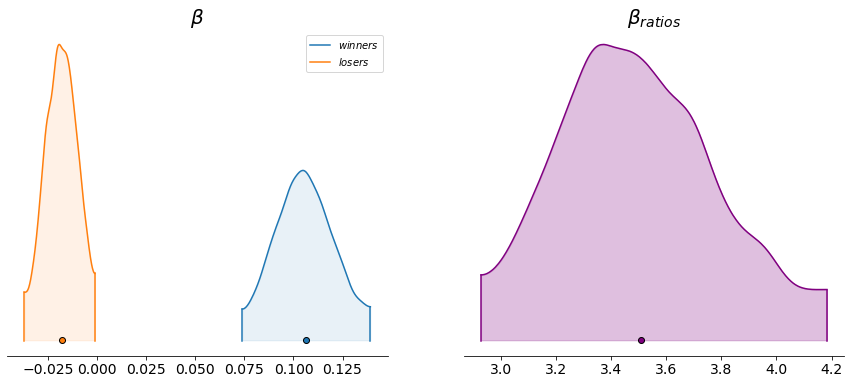

In [8]:
fig, ax = plt.subplots(1,2, figsize = [15,6])
az.plot_density(
    [trace['weight_win'], trace['weight_lose']],
    data_labels=["$winners$", 
                 "$losers$"],
    shade=.1, ax = ax[0], hdi_prob=.95, 
)
az.plot_density(
    [trace['weight_ratio']], hdi_prob=.95,
    data_labels=["$\\beta_{ratio}$"], outline=True,
    shade=.25, ax = ax[1], colors = 'purple', 
)
ax[0].set_title('$\\beta$', fontsize = 20)
ax[1].set_title('$\\beta_{ratios}$', fontsize = 20)
ax[0].legend(loc='upper right');


#fig.savefig('img/8_CB/posterior_weights_WNB.svg')

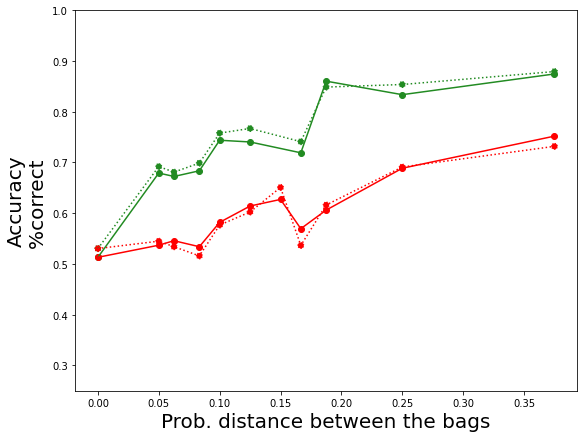

In [7]:
idx_cong = WNB['WinBigRatio']>WNB['WinSmallRatio'] #Congruent trial
idx_incong = ~idx_cong #Incongruent trial
ppc_cong = pd.concat([pd.DataFrame(ppc['choice'].mean(axis=0)[idx_cong], columns = ['choice_model']), 
                      WNB.loc[idx_cong,:].reset_index(drop=True)], axis = 1)
ppc_incong = pd.concat([pd.DataFrame(ppc['choice'].mean(axis=0)[idx_incong], columns = ['choice_model']), 
                        WNB.loc[idx_incong,:].reset_index(drop=True)], axis = 1)

toplot_cong = ppc_cong.groupby(['ProbDistance']).mean()[['choice_model','correct']].reset_index()
toplot_incong = ppc_incong.groupby(['ProbDistance']).mean()[['choice_model','correct']].reset_index()
idx1 = toplot_cong['ProbDistance']==0
idx2 = toplot_incong['ProbDistance']==0
mean0 = (toplot_cong.loc[idx1,'correct'] + toplot_incong.loc[idx2,'correct'])/2
toplot_cong.loc[idx1,'correct'] = mean0 #In prob. distance 0 congruent, incongruente doesn't apply
toplot_incong.loc[idx2,'correct'] = mean0
mean0 = (toplot_cong.loc[idx1,'choice_model'] + toplot_incong.loc[idx2,'choice_model'])/2
toplot_cong.loc[idx1,'choice_model'] = mean0 #In prob. distance 0 congruent, incongruente doesn't apply
toplot_incong.loc[idx2,'choice_model'] = mean0

fig = plt.figure(figsize=[9,7])
plt.plot(toplot_cong['ProbDistance'], toplot_cong['correct'], color = 'forestgreen', linestyle = ':')
plt.scatter(toplot_cong['ProbDistance'], toplot_cong['correct'], color = 'forestgreen', linestyle = ':')
plt.plot(toplot_incong['ProbDistance'], toplot_incong['correct'], color = 'red', linestyle = ':')
plt.scatter(toplot_incong['ProbDistance'], toplot_incong['correct'], color = 'red', linestyle = ':')

plt.plot(toplot_cong['ProbDistance'], toplot_cong['choice_model'], color = 'forestgreen')
plt.scatter(toplot_cong['ProbDistance'], toplot_cong['choice_model'], color = 'forestgreen')
plt.plot(toplot_incong['ProbDistance'], toplot_incong['choice_model'], color = 'red')
plt.scatter(toplot_incong['ProbDistance'], toplot_incong['choice_model'], color = 'red');

plt.ylim([0.25,1])
plt.xlabel('Prob. distance between the bags', fontsize = 20)
plt.ylabel('Accuracy\n%correct ', fontsize = 20);

#fig.savefig('img/8_CB/ppc_WNB.svg')

# Ejercicio

* Haga el diagrama de un modelo con un prior uniforme entre 0 y 1 para la fracción Weber por sujeto. 
    * Implemente el modelo en PyMC y compare el posterior del Weber con el valor fijo de 0.28. ¿Es mayor o menor? ¿Qué significa la diferencia?
* Haga el diagrama de un modelo jerárquico con un prior Normal para la fracción de Weber por sujeto. Haga el prior con hiperparametros mu y sigma uniforme entre 0 y 1. 

Una hipótesis alternativa es que la gente es estratégica. 

Si el denominador es igual (o casi igual), se comparan los numeradores. De lo contrario, se comparan los ratios.

Implementemos esta idea en PyMC

Usemos un soft threshold para usar o no ratio

$$pUseRatio_i = \frac{1}{1+e^{-k(Thr-rDen_i)}}$$

$pUseRatio_i$: Probabilidad de usar ratio en el turno i <br>
$k, \ Thr$: Sensibilidad y umbral, respectivamente. Parametros libres de la sigmoide <br>
$rDen_i$: ratio entre los denominadores de ambas bolsa ($Small_{ratio}/Big_{ratio}$)

In [ ]:
k = 3.2
Thr = 0.99
rDen = np.linspace(0,1,100)
pUseRatio = 1/(1+np.exp(-k*(Thr - rDen)))
plt.figure(figsize=(8,6))
plt.plot(rDen, pUseRatio);
plt.ylabel('Prob. use ratio', fontsize = 20)
plt.xlabel('Ratio between denominators (S/B)', fontsize = 20);

In [ ]:
with pm.Model() as WNB_strategic_model:
    
    #priors
    k = pm.Uniform('k', lower=0, upper=20)
    Thr = pm.Uniform('Thr', lower=0, upper=1)
    #percepts of winners and losers assumed different e.g. due to lose aversion
    Winners = pm.Normal('percept_winners', 
                        mu = winners, sd = weber*winners, shape = winners.shape)
    Losers = pm.Normal('percept_losers', 
                       mu = losers, sd = weber*losers, shape = losers.shape) 
    Ratios = pm.Beta('percept_ratios', 
                     alpha = ratios[:,0] + 1, 
                     beta = ratios[:,1] - ratios[:,0] + 1, shape = ratios.shape[0])
    
    #likelihood 
    w_1 = Winners[side1[:,0]]
    w_2 = Winners[side2[:,0]]
    l_1 = Losers[side1[:,0]]
    l_2 = Losers[side2[:,0]]
    d_1 = w_1 + l_1
    d_2 = w_2 + l_2
    rDen = tt.switch( d_1>=d_2, d_2/d_1, d_1/d_2)
    pUseRatio = 1/(1+tt.exp(-k*(Thr-rDen)))  
    f_side1 = pUseRatio*Ratios[side1[:,2]] + (1-pUseRatio)*Winners[side1[:,0]] 
    f_side2 = pUseRatio*Ratios[side2[:,2]] + (1-pUseRatio)*Winners[side2[:,0]] 
    softmax = tt.exp(f_side2)/(tt.exp(f_side1) + tt.exp(f_side2)) #prob. of picking side 2
   
    choice_LH = pm.Bernoulli( 'choice', p = softmax, observed=choice)
    
    
    print(f_side1.tag.test_value.shape, f_side2.tag.test_value.shape,
          softmax.tag.test_value.shape, choice_LH.tag.test_value.shape)
    
    #sampling
    trace_s = pm.sample(1000, init = 'adapt_diag', tune=1500, target_accept = 0.9)
    ppc_s = pm.sample_posterior_predictive(trace_s, samples=5000)
    data_s = az.from_pymc3(trace=trace_s)

In [ ]:
az.plot_trace(data_s, var_names=['k', 'Thr', 
                               'percept_winners', 'percept_losers', 'percept_ratios'], compact=True);

In [ ]:
y = trace['percept_winners'].mean(axis=0)
x = winners
plt.plot(x,y, label = 'intrinsic WNB')

y = trace_s['percept_winners'].mean(axis=0)
plt.plot(x,y, label = 'strategic')
plt.legend()
plt.title('Mean Percept Winners')

plt.figure()
y = trace['percept_losers'].mean(axis=0)
x = losers
plt.plot(x,y, label = 'intrinsic WNB')

y = trace_s['percept_losers'].mean(axis=0)
plt.plot(x,y, label = 'strategic')
plt.title('Mean Percept Losers')
plt.legend();

plt.figure()
y = trace['percept_ratios'].mean(axis=0)
x = ratios[:,2]
plt.scatter(x,y, label = 'intrinsic WNB')

y = trace_s['percept_ratios'].mean(axis=0)
plt.scatter(x,y, label = 'strategic')
plt.title('Mean Percept Ratios')
plt.legend();


In [ ]:
idx_cong = WNB['WinBigRatio']>WNB['WinSmallRatio'] #Congruent trial
idx_incong = ~idx_cong #Incongruent trial
ppc_cong = pd.concat([pd.DataFrame(ppc_s['choice'].mean(axis=0)[idx_cong], 
                                   columns = ['choice_model']), 
                      WNB.loc[idx_cong,:].reset_index(drop=True)], axis = 1)
ppc_incong = pd.concat([pd.DataFrame(ppc_s['choice'].mean(axis=0)[idx_incong], columns = ['choice_model']), 
                        WNB.loc[idx_incong,:].reset_index(drop=True)], axis = 1)

toplot_cong = ppc_cong.groupby(['ProbDistance']).mean()[['choice_model','correct']].reset_index()
toplot_incong = ppc_incong.groupby(['ProbDistance']).mean()[['choice_model','correct']].reset_index()
idx1 = toplot_cong['ProbDistance']==0
idx2 = toplot_incong['ProbDistance']==0
mean0 = (toplot_cong.loc[idx1,'correct'] + toplot_incong.loc[idx2,'correct'])/2
toplot_cong.loc[idx1,'correct'] = mean0 #In prob. distance 0 congruent, incongruente doesn't apply
toplot_incong.loc[idx2,'correct'] = mean0
mean0 = (toplot_cong.loc[idx1,'choice_model'] + toplot_incong.loc[idx2,'choice_model'])/2
toplot_cong.loc[idx1,'choice_model'] = mean0 #In prob. distance 0 congruent, incongruente doesn't apply
toplot_incong.loc[idx2,'choice_model'] = mean0

fig = plt.figure(figsize=[9,7])
plt.plot(toplot_cong['ProbDistance'], toplot_cong['correct'], color = 'forestgreen', linestyle = ':')
plt.scatter(toplot_cong['ProbDistance'], toplot_cong['correct'], color = 'forestgreen', linestyle = ':')
plt.plot(toplot_incong['ProbDistance'], toplot_incong['correct'], color = 'red', linestyle = ':')
plt.scatter(toplot_incong['ProbDistance'], toplot_incong['correct'], color = 'red', linestyle = ':')

plt.plot(toplot_cong['ProbDistance'], toplot_cong['choice_model'], color = 'forestgreen')
plt.scatter(toplot_cong['ProbDistance'], toplot_cong['choice_model'], color = 'forestgreen')
plt.plot(toplot_incong['ProbDistance'], toplot_incong['choice_model'], color = 'red')
plt.scatter(toplot_incong['ProbDistance'], toplot_incong['choice_model'], color = 'red');

plt.ylim([0.25,1])
plt.xlabel('Prob. distance between the bags', fontsize = 20)
plt.ylabel('Accuracy\n%correct ', fontsize = 20);

In [ ]:
#Model comparison 
with WNB_strategic_model:
    strategic_waic = pm.waic(trace_s) #, var_name = 'choice')
with WNB_model:
    intrinsic_waic = pm.waic(trace) #This calculates the elpd_waic (-2 times is the waic in deviance scale) 

#lower is better
print('Strategy WAIC (deviance scale):      ', -2*strategic_waic.waic) 
print('Intrinsic WNB WAIC (deviance scale): ', -2*intrinsic_waic.waic)



# Ejercicios

* Haga el diagrama del modelo estratégico
* Modifique el modelo WNB_model para simular otras tres hipótesis:
    * La gente solo compara ganadores (denominator neglect)
    * La gente compara ganadores y perdedores (just number)
    * La gente solo compara ratios (holistic ratios)
* Compare con WAIC los 5 modelos (intrinsic WNB, Strategic, Denominator neglect, Just number, Holistic ratios). Comente que aprendimos del comportamiento humano (e.g. por qué piensa que el peor lo es; o por que el mejor quedo de primero; por qué los humanos nos comportamos así).


Podemos estimar perceptos de numerosidad y ratio latentes con técnicas bayesianas ... 

... pero ¿es cognición de fracciones Bayesiana? Depronto. Dos argumentos y datos:

* Confianza sigue un sesgo bayesiano
* Hay un prior de fracciones altas con numeradores altas

Confianza sigue un sesgo bayesiano
<center><img src="img/8_CB/alonso15.png" width = "651" height = '650'></center>

Una percepción de ratios tipo Beta es más precisa con números mayores. 

Hipótesis (Beta) Bayesiana: la gente debe tener mayor confianza en el mismo ratio pero con números grandes.

<center><img src="img/8_CB/alonso9.png" width = "551" height = '550'></center>

Experimento: 
* Escoja la bolsa con mejor probabilidad de sacar una bola naranja. 232 turnos
* 100 mTurkers (final n = 82)
* 3 distancias de prob. entre las bolsas
* 2 condiciones: cardinalidad (alta y baja) y congruencia (cong. e incong)
* Confianza post decision 


<center><img src="img/8_CB/alonso10.png" width = "451" height = '450'></center>

<center><img src="img/8_CB/alonso11.png" width = "451" height = '450'></center>

Bolsas con alta cardinalidad reducian calificaciones bajas de confianza (2)

Bolsas con baja cardinalidad aumentaban calificaciones bajas de confianza (2)


<center><img src="img/8_CB/alonso12.png" width = "400" height = '400'></center>

¿Podrá ser un artefacto de preguntar explícitamente? 

La misma tarea pero ahora se escoge moviendo el dedo a una pantalla (grabación de infrarojos en la punta del dedo).   

Supuesto: trayectoria como proxy de confianza implícita (i.e. el sujeto luego de varios turnos se mueve rápido)

<center><img src="img/8_CB/alonso13.png" width = "551" height = '550'></center>

La trayectoria era más confiada con ratios con numeros altos (dificultad constante de 0.1)
<br><br>
<center><img src="img/8_CB/alonso14.svg" width = "451" height = '450'></center>

Los datos son consistentes con la hipótesis bayesiana para fracciones.

<center><img src="img/8_CB/alonso9.png" width = "351" height = '350'></center>

Otra pista bayesiana es la existencia de un prior fuerte en la realidad.
<br><br>
<center><img src="img/8_CB/alonso16.svg" width = "651" height = '650'></center>

¿Por qué el gap? ¿Óptimo? Sí, si comparo más rápido numeradores y estos son un proxi del valor fraccional.

<center><img src="img/8_CB/alonso6.png" width = "551" height = '550'></center>

Segun Bayes,

$$p(RL|NL) = \frac{p(NL|RL)p(RL)}{p(NL)}$$

donde R: ratio, N: numerador, D: denominador, L: larger, S: smaller.

Para sugerir pseudo-optimalidad bayesiana, p(RL|NL) deber ser mayor a todos los demás posteriors

$$p(RL|NL) > p(RL|NS) > p(RL|DL) > p(RL|DS)$$

De hecho, si la magnitud del ratio y el denominador son independientes se puede mostrar que es muy probable ese ordenamiento

In [ ]:
#Generate counts for a specific category
folder_name = 'Warhol' #We included 4 folders as examples (go to Kaggle or Caltech256 website for others)
dirr = 'data/8_CB/Distribution-of-fractions/Example_Images/' + folder_name + '/'
name_files = [name for name in os.listdir(dirr) if (os.path.isfile(dirr+name)) & (name != '.DS_Store')]
n_files = len(name_files)

# Counts
results = mf2.img_counts(dirr, name_files, progress = False) #This takes a while
hue_bands = 4 #total number of hue bands (see img_counts)
NUM = [[], [], [], []]  # pixels of hue
DEN = [[], [], [], []]
NUM_B = [[], [], [], []]  # brightness of hue
DEN_B = [[], [], [], []]
NUM_S = [[], [], [], []]  # saturation of hue
DEN_S = [[], [], [], []]
for hb in range(hue_bands):
    NUM[hb].append(results[0][hb])
    DEN[hb].append(results[1][hb])
    
    NUM_B[hb].append(results[2][hb])
    DEN_B[hb].append(results[3][hb])
    
    NUM_S[hb].append(results[4][hb])
    DEN_S[hb].append(results[5][hb])


# Posteriors for all categories by HSV dimensions. 
# In "Example of one image category"  we show how we calculated
# posteriors. Specifically, see the function dropdown_callback 
# and the call to my_posterior in my_fun.py.

caltech256_h = pd.read_csv('data/8_CB/Distribution-of-fractions/tableCaltech_hue.csv')
caltech256_s = pd.read_csv('data/8_CB/Distribution-of-fractions/tableCaltech_sat.csv')
caltech256_v = pd.read_csv('data/8_CB/Distribution-of-fractions/tableCaltech_bright.csv')
paints_h = pd.read_csv('data/8_CB/Distribution-of-fractions/tablePaints_hue.csv')
paints_s = pd.read_csv('data/8_CB/Distribution-of-fractions/tablePaints_sat.csv')
paints_v = pd.read_csv('data/8_CB/Distribution-of-fractions/tablePaints_bright.csv')

In [ ]:
# Random images to initialize (changeable in the widget below)
rnd1 = np.random.randint(n_files)
rnd2 = np.random.randint(n_files)
name_files.sort()
NUMS = [NUM, NUM_B, NUM_S]
DENS = [DEN, DEN_B, DEN_S]

wHue = widgets.Dropdown(options=[('Red-yellow', 0), ('Yellow-green', 1), ('Green-blue', 2), ('Blue-purple',3)],
                        value=3,
                        description='Hue band: ')
wDim = widgets.Dropdown(options=[('Hue', 'hue'), ('Saturation', 'saturation'), ('Brightness', 'brightness')],
                        value='hue',
                        description='HSV dimension: ')
wImg1 = widgets.Dropdown(options= name_files, value=name_files[rnd1], description='Image 1: ')
wImg2 = widgets.Dropdown(options= name_files,value=name_files[rnd2],description='Image 2: ')

out = widgets.interactive_output(mf2.dropdown_callback, 
                                 {'hue': wHue, 'hsv_dim': wDim, 
                                  'img1': wImg1, 'img2': wImg2, 
                                  'dirr': fixed(dirr), 'NUMS': fixed(NUMS), 'DENS': fixed(DENS)})

left_widgets = VBox([wHue, wDim])
right_widgets = VBox([wImg1, wImg2])
top = HBox([left_widgets, right_widgets])
VBox([top, out])

En imagenes ratio y denominador son independientes ($p(RL|DL=p(RL|DS)=0.5$). 

Dada esta condición, p(RL|NL) es muy alto en millones de comparaciones binarias de imagenes naturales y pinturas.
<br><br>
<center><img src="img/8_CB/alonso17.svg" width = "751" height = '750'></center>

No sólo en imagenes, también en muchos dominios p(RL|NL) es mayor (aunque la razón no es 100% clara pues $p(RL|DL\ne p(RL|DS)\ne 0.5$)
<br><br>
<center><img src="img/8_CB/alonso18.svg" width = "751" height = '750'></center>

Con herramientas y conceptos bayesianos pudimos demostrar:

* Usar numeradores no implica no usar ratios.
* Sesgo bayesiano en confiar en ratios con cardinalidad alta.
* Prior p(RL|NL) alto en imagenes y otros dominios como libros de texto, videojuegos, economía.

Cambiemos de tema un poco

<center><img src="img/8_CB/LeeSarnecka1.svg" width = "751" height = '750'></center>

Teoría de number-knower. Los primeros numerales (1 a aprox. 4) se aprenden por ensayo y error (N-knower). Si se le pide un número mayor al nivel number-knower, el niño/niña es aleatorio.  

A partir de cierta edad se pasa a ser cardinal-principle knower (CP-knower) donde numerales sucesivos indican mayor numerosidad. Hay un salto/inferencia en la mente de la niña/niño. 

<center><img src="img/8_CB/LeeSarnecka2.svg" width = "651" height = '650'></center>

$\pi$: base rate prob. of giving/reporting k objects back witout any demand e.g. "take 4 just because" (max: 15) <br>
$z_i$: N-knower level (PN-knower, one-knower, two-knower, three-knower, four-knower, and CP-knower) <br>
$q_{ij}^g, \ a_{ij}^g $: question and answer of child i in trial j <br>
$\pi_{jik}^{'}$: updated rate prob. of giving/reporting k objects back after the question <br>
>"... if three-knower is asked to give five, they become much less likely to give 1, 2, or 3, but equally relatively likely to give 4 and above." Lee & Wagenmakers, 2013 (pp. 238)

$\nu$: strength of the updating

<center><img src="img/8_CB/LeeSarnecka3.svg" width = "751" height = '750'></center>



In [ ]:
## Modelos basados en https://github.com/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3
#load data
fa = pd.read_csv("data/8_CB/fa.csv") #answers (for fast-cards task) (rows: children; columns: trial)
fq = pd.read_csv("data/8_CB/fq.csv") #questions (for fast-cards task)
ga = np.array(pd.read_csv("data/8_CB/ga.csv")) #answers (for give-n task)
gq = np.array(pd.read_csv("data/8_CB/gq.csv")) #questions (for give-n task)
fnq = pd.read_csv("data/8_CB/fnq.csv")
gn = int(pd.read_csv("data/8_CB/gn.csv").iloc[0]) #max number of toys considered by the child (give-n task)
fn = 50 #max number of toys considered by the child (fast-cards task)
gnq = pd.read_csv("data/8_CB/gnq.csv")
ns = int(pd.read_csv("data/8_CB/ns.csv").iloc[0]) #number of subjects
nz = int(pd.read_csv("data/8_CB/nz.csv").iloc[0]) #proposed number-knower levels


In [ ]:
ind5 = np.zeros((nz, gn, gn), dtype=int) 
#cells in ind5 have: three levels/indices of situations (see comment in ind5r below) by knower-level, number asked, number responded
for i in range(nz): #number-knower levels (z in the graphical model)
    i1 = i + 1
    for j in range(gn): #These loops creates a 3D array ind5 to implement pi_{ijk}
        j1 = j + 1
        for k in range(gn): 
            k1 = k + 1
            # Will be 1 if Knower-Level is Same or Greater than Answer
            ind1 = int(i1 - 1 >= k1)
            # Will be 1 for the Possible Answer that Matches the Question
            ind2 = int(k1 == j1)
            # Will be 1 for 0-Knowers
            ind3 = int(i1 == 1)
            # Will be 1 for CP-Knowers
            ind4 = int(i1 == nz)
            ind5[i, j, k] = (
                ind3
                + ind4 * (2 + ind2)
                + (1 - ind4) * (1 - ind3) * (ind1 * ind2 + ind1 + 1)
            )
            #for a zero-knower: 1
            #for a CP-knower for a k that matches question: 1*(2+1) = 3 
            #for a CP-knower for a k that doesn't matches question: 1*(2) = 2
            #for a N-knower for a k that matches question and knower level is enough: (1*1 + 1 + 1) = 3
            #for a N-knower for a k that doesn't matches question and knower level is enough:: (1+1) = 2 
            #for a N-knower for a k that matches question and knower level is not enough: (1) = 1
            #for a N-knower for a k that doesn't matches question and knower level is not enough: (1) = 1
            
ind5r = ind5 - 1 
#0: impossible number demand (first condition of pi_{ijk}) 
#1 too easy or number wasn't asked (third condition of pi_{ijk})
#2 just perfect, at limit of knower-level (second condition of pi_{ijk})
ga_obs = np.asarray(ga.flatten() - 1, dtype=int)
gq_obs = np.asarray(gq.flatten() - 1, dtype=int)
valid_ind = np.where(gq_obs != -1)[0] #to clean data, my guess is that 0 means children didn't respond?

In [ ]:
with pm.Model() as model1:
    #priors
    pi = pm.Dirichlet("pi", a=np.ones(gn), shape=gn)

    nu = pm.Uniform("nu", lower=1, upper=1000)
    nu_vec = tt.stack([1.0, #first condition of pi_{ijk} (before nu multiplication)
                       1.0 / nu, #third condition of pi_{ijk} (before nu multiplication)
                       nu]) #second condition of pi_{ijk} (before nu multiplication)

    piprime = tt.mul(nu_vec[ind5r], pi) #multiplication by nu
    npiprime = piprime / tt.sum(piprime, axis=-1, keepdims=True) #normalized pi prime for categorical likelihood

    zi = pm.Categorical("zi", p=np.ones(nz) / nz, shape=ns) #knower level z per children s in dataset
    zi_vec = tt.repeat(zi, gq.shape[1]) #nz x number of questions 
    #print(zi_vec.tag.test_value.shape)
    
    #likelihoods
    pi_ij = npiprime[zi_vec[valid_ind], gq_obs[valid_ind], :]
    aij = pm.Categorical("aij", p=pi_ij, observed=ga_obs[valid_ind])
    
    #sampling
    trace1 = pm.sample()
    ppc1 = pm.sample_posterior_predictive(trace1, samples=5000)
    data1 = az.from_pymc3(trace=trace1)

In [ ]:
az.plot_trace(data1,  var_names=["pi", "nu", "zi"], compact=True);


La posterior promedio para pi, es decir la probabilidad base promedio de dar un número está sesgada a 1 y cae rápidamente con un incremento al final en dar todos los objetos.

In [ ]:
pitr = trace1["pi"]

fig = plt.figure(figsize=(18, 6))
plt.bar(np.arange(15) + 1, np.mean(pitr, axis=0), align="center")
plt.xlabel("Number")
plt.ylabel("Probability")
plt.xticks(np.arange(16))
plt.xlim([0, 16]);

La posterior esta centrada alrededor de solo un knower-level en todos los niños.

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
gs = axes.flatten()
zitr = trace1["zi"]

for i in range(ns):
    ax = gs[i]
    bartmp = np.unique(zitr[:, i], return_counts=True)
    ax.bar(bartmp[0], bartmp[1])
    ax.set_title("Child %s" % (i + 1))
    ax.set_xlim([-0.9, 5.9])
    ax.set_xticks(np.arange(6))
    ax.set_xticklabels(["P", "1", "2", "3", "4", "C"])

plt.subplot(gs[15])
plt.xlabel("Knower Level")
plt.ylabel("Posterior Mass")
plt.tight_layout();

In [ ]:
# Generate posterior prediction for each subject
gqpred = np.tile(np.arange(gn)[np.newaxis, :], (ns, 1)).flatten()

# Generate posterior prediction for each knower level
zpred = np.tile(np.arange(gn)[np.newaxis, :], (nz, 1)).flatten()
z_vect = np.tile(np.arange(nz)[:, np.newaxis], (1, gn)).flatten()

nutr = trace1["nu"]
tracelen = nutr.shape[0]
nsample = 500
predga = np.zeros((nsample, len(gqpred)))
predz = np.zeros((nsample, len(zpred)))
randlist = np.random.choice(tracelen, nsample)

In [ ]:
def caterandom(p):
    return np.asarray([np.random.choice(len(p1), p=p1) for p1 in p])


for i, idx in enumerate(randlist):
    pi1, nu1, zi1 = pitr[idx], nutr[idx], zitr[idx] #tr stands for trace from the model

    nu_vec1 = np.stack([1.0, 1.0 / nu1, nu1])
    piprime1 = np.multiply(nu_vec1[ind5r], pi1)
    npiprime1 = piprime1 / np.sum(piprime1, axis=-1, keepdims=True)

    zi_vec2 = np.repeat(zi1, gn)
    pi_ij_pred = npiprime1[zi_vec2, gqpred, :]
    predga[i, :] = caterandom(pi_ij_pred)

    zi_ij_pred = npiprime1[z_vect, zpred, :]
    predz[i, :] = caterandom(zi_ij_pred)

Podemos predecir cuantos objetos un niño va a dar. Por ejemplo, el niño 20 es un CP-knower y el model predice que siempre va a dar la respuesta correcta (circulos rojos es la data, y colores calidos indican probabilidades más fuertes para el modelo).

Child 15 is a 0-knower, child 2 is a 1-knower, child 4 is a 2-knower, child 3 is a 3-knower, child 10 is a 4-knower (see previous plot).

In [ ]:
predga = np.reshape(predga, newshape=(nsample, ns, gn)).astype(int)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
gs = axes.flatten()
subjlist = np.asarray([15, 2, 4, 3, 10, 20]) - 1

for i, isbj in enumerate(subjlist):
    mattmp = np.squeeze(predga[:, isbj, :])
    obs = ga[isbj] - 1
    qus = gq[isbj] - 1
    msk = qus != -1
    img_ = np.zeros((gn, gn))
    for j in range(gn):
        bartmp = np.unique(mattmp[:, j], return_counts=True)
        img_[j, bartmp[0]] = bartmp[1]
    ax = gs[i]
    ax.imshow(img_.T, cmap="viridis", origin="lower")
    ax.plot(qus[msk], obs[msk], "o", ms=15, color="r", alpha=0.5)
    ax.grid("off")
    ax.set_title("Child %s" % (isbj + 1))

plt.subplot(gs[3])
plt.xlabel("Question")
plt.ylabel("Answer")
plt.tight_layout();

En general, la imagen siguiente muestra las predicciones del modelo por knower-level. Sigue la intuición: e.g. los cuadros amarillos para un 3 knower van hasta 3, luego los colores azules se ponen más frios.

In [ ]:
predz = np.reshape(predz, newshape=(nsample, nz, gn)).astype(int)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
gs = axes.flatten()
knowertype = (
    "PN-Knower",
    "One-Knower",
    "Two-Knower",
    "Three-Knower",
    "Four-Knower",
    "CP-Knower",
)

for i in range(nz):
    mattmp = np.squeeze(predz[:, i, :])
    img_ = np.zeros((gn, gn))
    for j in range(gn):
        bartmp = np.unique(mattmp[:, j], return_counts=True)
        img_[j, bartmp[0]] = bartmp[1]
    ax = gs[i]
    ax.imshow(img_.T, cmap="viridis", origin="lower")
    ax.grid("off")
    ax.set_title(knowertype[i])

plt.subplot(gs[3])
plt.xlabel("Question")
plt.ylabel("Answer")
plt.tight_layout();

# Ejercicios

* Haga un gráfico que represente mejor el posterior de $pi$. Arriba solo se gráfico el promedio. 
* ¿Qué opina si clasificamos el knower-level de niños/niñas usando el máximo a posteriori (MAP) del parámetro zi? Por ejemplo, ¿qué opina de clasificar al niño 8 cómo 1-knower? Piense en alguna alternativa al MAP




Podemos describir/medir etapas de desarrollo numérico de niños y niñas con técnicas bayesianas ... pero ¿un modelo Bayesiano puede *explicar* por qué va por etapas? Si. 

<center><img src="img/8_CB/Piantadosi1.svg" width = "651" height = '650'></center>

Suponga que el cerebro tiene primitivos 
<br><br>

<center><img src="img/8_CB/Piantadosi2.svg" width = "751" height = '750'></center>

Suponga que la labor durante el desarrollo es encontrar como se combinan esos primitivos. El niño tiene que inferir cuál combinación es la apropiada. Tiene que explorar un espacio de hipótesis enorme. Acá algunas.
<br><br>

<center><img src="img/8_CB/Piantadosi3.svg" width = "751" height = '750'></center>

A medida que hay más datos (exposición a expresiones númericas) el posterior va evolucionando por las etapas que vemos en niños y niñas: de 1-knower a CP-Knower. 

Los datos vuelven algunas hipótesis más probables.

<center><img src="img/8_CB/Piantadosi4.svg" width = "751" height = '750'></center>

Depende de la data para evolucionar en el espacio de hipótesis. Esto se ve en diferentes culturas. Los Tsimane en particular van más lento (menos exposición a números) pero la misma progresión (Piantadosi, et al, 2014).
<br><br>
<center><img src="img/8_CB/Piantadosi5.svg" width = "551" height = '550'></center>

# Conclusión

* Con Bayes se puede describir comportamiento numérico (adultos y menores).
* Con Bayes también se puede testear comportamiento numérico Bayesiano.

# Appendix

In [ ]:
#Intrinsic whole number bias
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Whole Number Bias";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=plaintext,\
                 height=0.25, width=0.25, lblstyle="font=\\small"];\
           /* links */\
           w -> pw;\
           l -> pl;\
           w -> pratio;\
           l -> pratio;\
           pw -> choice;\
           pl -> choice;\
           pratio -> choice;\
           subgraph cluster0 {\
               margin = 10; labeljust=l; lblstyle="font=\\small";\
               style = rounded;\
               label = "$i trial$";\
               choice;\
               subgraph cluster1 {\
                   margin = 10; labeljust=l; lblstyle="font=\\small";\
                   style = rounded;\
                   label = "$r ratio = [Small, Big]$";\
                   w;\
                   pw;\
                   l;\
                   pl;\
                   pratio;\
               }\
           }\
           /* nodes */\
           w [label = "$W_{ir}$", fillcolor = gray, style = filled, shape = square];\
           l [label = "$L_{ir}$", fillcolor = gray, style = filled, shape = square];\
           pw [label = "$\Phi(W_{ir})$", shape = circle];\
           pl [label = "$\Phi(L_{ir})$", shape = circle];\
           pratio [label = "$Ratio_{ir}$", shape = circle];\
           choice [label = "$Choice_i$", fillcolor = gray, style = filled, shape = square];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/8_CB/model_WNB.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#distributions:
# \Phi(W_{ir}) \sim N(W_{ir}, Weber \times W_{ir})
# \Phi(L_{ir}) \sim N(L_{ir}, Weber \times L_{ir})
# Ratio_{ir} \sim Beta(W_{ir} + 1, L_{ir} + 1)
# Choice_i \sim Bernoulli(pSM_i)
# pSM_i = \frac{e^{f_{iB}}}{e^{f_{iB}}+e^{f_{iS}}}
# f_{ir} = \beta_1 \Phi(W_{ir}) + \beta_2 \Phi(L_{ir}) + \beta_3 Ratio_{ir}
# \beta_{num cues} Uniform(-5,5)
# \beta_{ratio cue} Uniform(0,5)

#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{34pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}